In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import timm

/home/camilo/Downloads/IA medicos/IAMedicos/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

metadata_path = "../dataverse_files/HAM10000_metadata"
data_dir = "../dataverse_files"
df = pd.read_csv(metadata_path)

# Remove duplicates (HAM10000 has duplicate images)
df_unique = df.drop_duplicates(subset=["image_id"])

# Class distribution
class_counts = df_unique["dx"].value_counts()

# Stratified split
train_df, val_df = train_test_split(
    df_unique, test_size=0.2, stratify=df_unique["dx"], random_state=42
)

test_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

checkpoint = torch.load("./models/ham10000_efficientnet_b4.pth", map_location=device)

model = timm.create_model(
    "tf_efficientnet_b4",
    pretrained=False,  # ImageNet weights
    num_classes=7,
)

model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNo

In [3]:
label_map = {"akiec": 0, "bcc": 1, "bkl": 2, "df": 3, "mel": 4, "nv": 5, "vasc": 6}
labels_train = train_df["dx"].map(label_map).values

class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(labels_train), y=labels_train
)
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))


def evaluate_dataset(test_dir, name, model, transform, batch_size=32, num_workers=12):
    test_dataset = datasets.ImageFolder(test_dir, transform=transform)
    val_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available(),
    )

    model.eval()

    all_labels = []
    all_preds = []
    all_probs = []

    val_loss_batches = []
    val_acc_batches = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(probs, 1)

            correct = (preds == labels).sum().item()
            acc = correct / labels.size(0)

            val_loss_batches.append(loss.item())
            val_acc_batches.append(acc)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    avg_val_loss = float(np.mean(val_loss_batches))
    avg_val_acc = float(np.mean(val_acc_batches))
    precision = precision_score(all_labels, all_preds, average="macro", zero_division=0)
    recall = recall_score(all_labels, all_preds, average="macro", zero_division=0)
    f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)

    print(f"[{name}] Val loss: {avg_val_loss:.4f}")
    print(f"[{name}] Val accuracy: {avg_val_acc:.4f}")
    print(f"[{name}] Precision (macro): {precision:.4f}")
    print(f"[{name}] Recall (macro): {recall:.4f}")
    print(f"[{name}] F1 (macro): {f1:.4f}")

    return {
        "name": name,
        "loss_batches": val_loss_batches,
        "acc_batches": val_acc_batches,
        "avg_loss": avg_val_loss,
        "avg_acc": avg_val_acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "labels": all_labels,
        "preds": all_preds,
        "probs": all_probs,
    }


In [4]:
paths = {
    "Fitz_12": "../test_dataset/12",
    "Fitz_34": "../test_dataset/34",
    "Fitz_56": "../test_dataset/56",
}

results = {}
for name, p in paths.items():
    results[name] = evaluate_dataset(p, name, model, test_transform)


[Fitz_12] Val loss: 4.7970
[Fitz_12] Val accuracy: 0.1911
[Fitz_12] Precision (macro): 0.1223
[Fitz_12] Recall (macro): 0.1296
[Fitz_12] F1 (macro): 0.1157
[Fitz_34] Val loss: 3.8643
[Fitz_34] Val accuracy: 0.2550
[Fitz_34] Precision (macro): 0.1721
[Fitz_34] Recall (macro): 0.1871
[Fitz_34] F1 (macro): 0.1680
[Fitz_56] Val loss: 4.2482
[Fitz_56] Val accuracy: 0.2775
[Fitz_56] Precision (macro): 0.2472
[Fitz_56] Recall (macro): 0.2074
[Fitz_56] F1 (macro): 0.2035


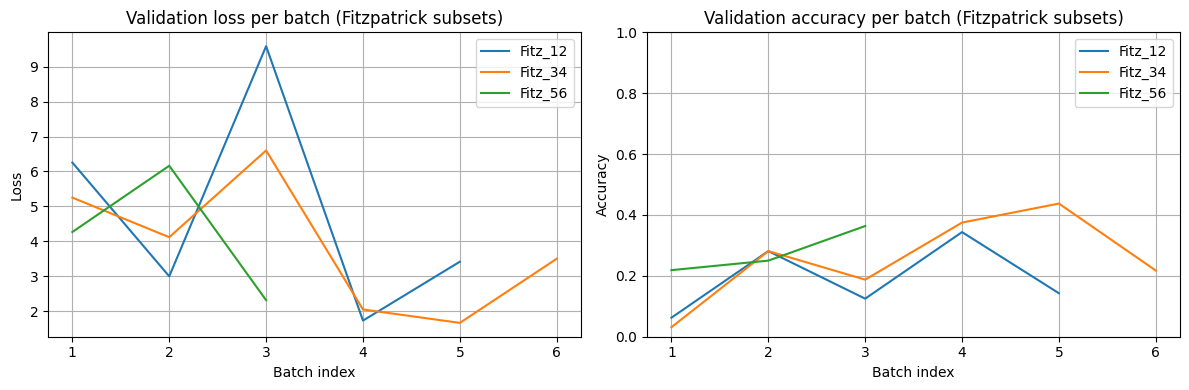

In [5]:
plt.figure(figsize=(12, 4))

# Overlapping loss curves
plt.subplot(1, 2, 1)
for name, res in results.items():
    steps = range(1, len(res["loss_batches"]) + 1)
    plt.plot(steps, res["loss_batches"], label=name)
plt.xlabel("Batch index")
plt.ylabel("Loss")
plt.title("Validation loss per batch (Fitzpatrick subsets)")
plt.grid(True)
plt.legend()

# Overlapping accuracy curves
plt.subplot(1, 2, 2)
for name, res in results.items():
    steps = range(1, len(res["acc_batches"]) + 1)
    plt.plot(steps, res["acc_batches"], label=name)
plt.xlabel("Batch index")
plt.ylabel("Accuracy")
plt.title("Validation accuracy per batch (Fitzpatrick subsets)")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


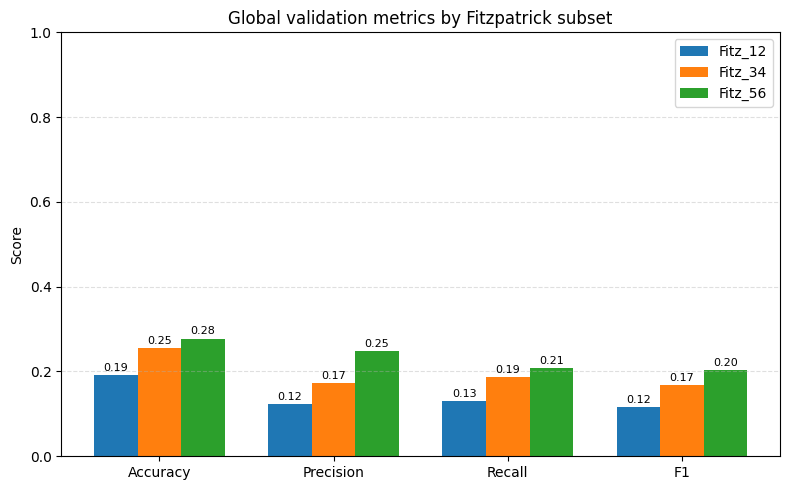

In [6]:
datasets_names = list(results.keys())
metrics_names = ["Accuracy", "Precision", "Recall", "F1"]

metric_matrix = []
for name in datasets_names:
    r = results[name]
    metric_matrix.append([r["avg_acc"], r["precision"], r["recall"], r["f1"]])

metric_matrix = np.array(metric_matrix)  # shape: (num_datasets, 4)

x = np.arange(len(metrics_names))
width = 0.25  # bar width

plt.figure(figsize=(8, 5))
for i, name in enumerate(datasets_names):
    plt.bar(x + i * width, metric_matrix[i], width=width, label=name)

plt.xticks(x + width, metrics_names)
plt.ylim(0, 1)
for i in range(len(datasets_names)):
    for j in range(len(metrics_names)):
        v = metric_matrix[i, j]
        plt.text(x[j] + i * width, v + 0.01, f"{v:.2f}", ha="center", fontsize=8)

plt.title("Global validation metrics by Fitzpatrick subset")
plt.ylabel("Score")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


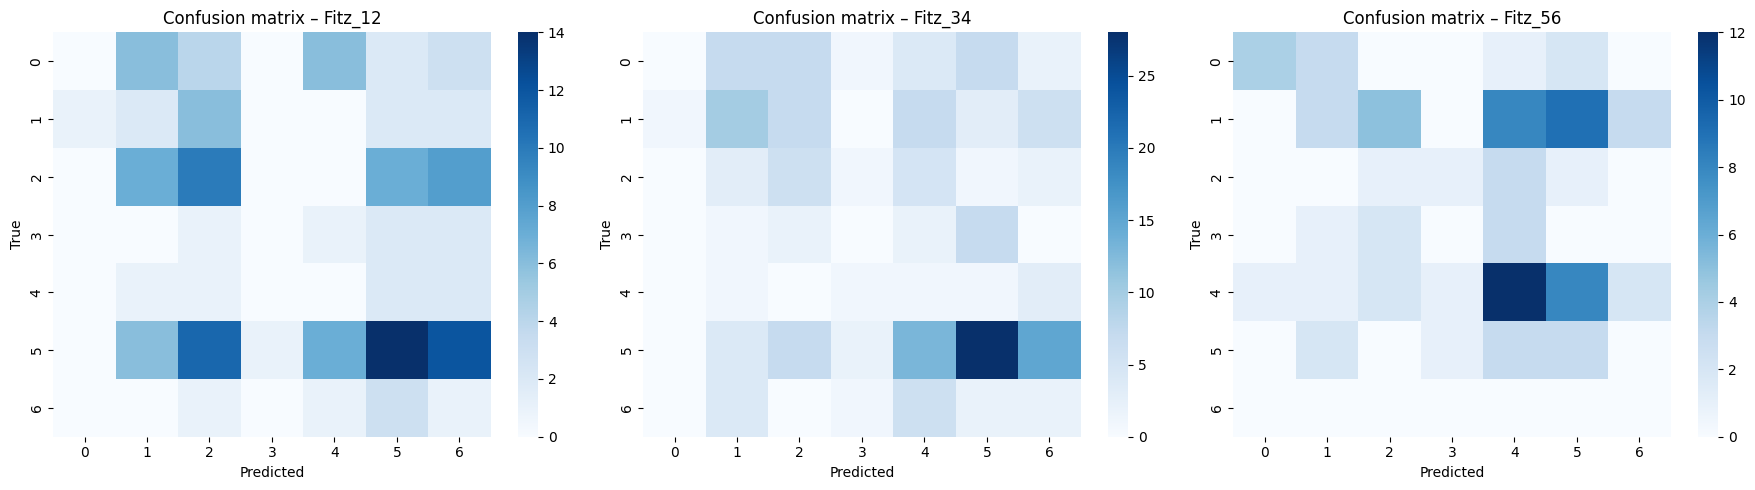

In [7]:
num_sets = len(results)
plt.figure(figsize=(6 * num_sets, 5))

for idx, (name, res) in enumerate(results.items(), start=1):
    cm = confusion_matrix(res["labels"], res["preds"])
    plt.subplot(1, num_sets, idx)
    sns.heatmap(cm, annot=False, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion matrix – {name}")

plt.tight_layout()
plt.show()
